In [1]:
import time
import os

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim
from torch.utils.data import DataLoader

import models.loadImg as loadImg
import models.modelsCNN as modelsCNN
import models.optimizer as optimizer

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc
from skimage import io


In [2]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "0,1,2,3" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3" 

In [3]:
radius=48
patchsize=16*9
datadir='/media/xinyi/dcis2idc/data'
sampleList=[]
for s in os.listdir('/media/xinyi/dcis2idc/data'):
    if 'hoechst'  in s and ('_1_' in s or '_3_' in s or '_4_' in s or '_6_' in s):
#     if 'hoechst'  in s and ('_3_' in s or '_4_' in s or '_6_' in s):
        sampleList.append(s)
print(sampleList)
trainingCores={'br1003a':[],'br8018a':[],'br301':[]}
for s in range(1,11):
# for s in range(5,11):
    trainingCores['br1003a'].append('A'+str(s))
    trainingCores['br1003a'].append('C'+str(s))
    trainingCores['br1003a'].append('I'+str(s))
for s in range(1,11):
    if s<9:
        trainingCores['br8018a'].append('H'+str(s))
    trainingCores['br8018a'].append('A'+str(s))
    trainingCores['br8018a'].append('B'+str(s))
    trainingCores['br8018a'].append('F'+str(s))
for s in range(1,7):
    for sr in ['A','B','C','D','E']:
        trainingCores['br301'].append(sr+str(s))

['br1003a_1_cytokeratin_555_aSMA_647_hoechst', 'br1003a_3_collagen1_647_hoechst', 'br1003a_4_cytokeratin_555_gh2ax_647_hoechst', 'br301_4_cytokeratin_555_aSMA_647_hoechst', 'br301_6_collagen1_647_hoechst', 'br8018a_1_cytokeratin_555_aSMA_647_hoechst', 'br8018a_3_collagen1_647_hoechst', 'br8018a_4_cytokeratin_555_gh2ax_647_hoechst']


In [4]:
with open(os.path.join(datadir,'processed','train_cnnvae_names'), 'rb') as input:
    allImgNames=pickle.load(input)
with open(os.path.join(datadir,'processed','train_cnnvae_cellLabels'), 'rb') as output:
    cellIDlist=pickle.load(output)
    
ep=311
np.random.seed(6)
plotPCT=4500
plottingIdx_i=np.array([])
n_pcs=50
for i in range(1):
    for s in np.unique(allImgNames):
        nsamples=min(int(np.sum(allImgNames==s)),plotPCT)
        plottingIdx_i=np.concatenate((plottingIdx_i,
                                    np.random.choice(np.arange(allImgNames.shape[0])[allImgNames==s],nsamples,replace=False)))
nimages=plottingIdx_i.size
allImg_patch,allmasks_patch=loadImg.loadImg_patch(plottingIdx_i,allImgNames,cellIDlist,datadir,sampleList,trainingCores,'segmented_nucleus','zproject/dna',radius,patchsize,('br8018a_4_cytokeratin_555_gh2ax_647_hoechst',['H2','H4','H7']),nimages=nimages,minmax=True)

br1003a_1_cytokeratin_555_aSMA_647_hoechst
A1
C1
I1
A2
C2
I2
C3
I3
A4
C4
A5
C5
A6
C6
A7
C7
I7
A8
C8
I8
A9
C9
I9
C10
I10
br1003a_3_collagen1_647_hoechst
A1
C1
I1
A2
C2
I2
A3
C3
I3
C4
A5
C5
A6
C6
A7
C7
I7
A8
C8
I8
A9
C9
I9
C10
I10
br1003a_4_cytokeratin_555_gh2ax_647_hoechst
A1
C1
I1
A2
C2
I2
A3
I3
A4
C4
A5
C5
A6
C6
A7
C7
I7
A8
C8
I8
A9
C9
I9
A10
C10
br301_4_cytokeratin_555_aSMA_647_hoechst
A1
B1
C1
D1
E1
A2
B2
C2
D2
E2
A3
B3
C3
D3
E3
A4
B4
C4
D4
E4
A5
B5
C5
D5
E5
A6
B6
C6
D6
E6
br301_6_collagen1_647_hoechst
A1
B1
C1
D1
E1
A2
B2
C2
D2
E2
A3
B3
C3
D3
E3
A4
B4
C4
D4
E4
A5
B5
C5
D5
E5
A6
B6
C6
D6
E6
br8018a_1_cytokeratin_555_aSMA_647_hoechst
H1
A1
B1
F1
H2
A2
B2
F2
H3
A3
B3
F3
H4
A4
B4
F4
H5
A5
B5
F5
H6
A6
B6
F6
H7
A7
B7
F7
H8
A8
B8
F8
A9
F9
A10
B10
F10
br8018a_3_collagen1_647_hoechst
A1
B1
A2
B2
A3
B3
F3
A4
B4
F4
B5
A6
B6
F6
A7
B7
F7
A8
B8
F8
A9
B9
F9
B10
F10
br8018a_4_cytokeratin_555_gh2ax_647_hoechst
H1
A2
H3
A3
F3
B4
F4
H5
A5
B5
H6
B6
A7
B7
F7
H8
A8
F8


In [5]:
with open(os.path.join(datadir,'processed','train_cnnvae_patch'+'_plottingIdx_'+str(plotPCT)+'_'+str(i)+'flt32'), 'wb') as output:
    pickle.dump(allImg_patch, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(datadir,'processed','train_cnnvae_patchMask'+'_plottingIdx_'+str(plotPCT)+'_'+str(i)+'flt32'), 'wb') as output:
    pickle.dump(allmasks_patch, output, pickle.HIGHEST_PROTOCOL)

In [4]:
# nimages=1876734
# allImg_patch,allmasks_patch=loadImg.loadImg_patch(datadir,sampleList,trainingCores,'segmented_nucleus','zproject/dna',radius,patchsize,('br8018a_4_cytokeratin_555_gh2ax_647_hoechst',['H2','H4','H7']),nimages=nimages,minmax=True)

br1003a_1_cytokeratin_555_aSMA_647_hoechst
A1
C1
I1
A2
C2
I2
C3
I3
A4
C4
A5
C5
A6
C6
A7
C7
I7
A8
C8
I8
A9
C9
I9
C10
I10
br1003a_3_collagen1_647_hoechst
A1
C1
I1
A2
C2
I2
A3
C3
I3
C4
A5
C5
A6
C6
A7
C7
I7
A8
C8
I8
A9
C9
I9
C10
I10
br1003a_4_cytokeratin_555_gh2ax_647_hoechst
A1
C1
I1
A2
C2
I2
A3
I3
A4
C4
A5
C5
A6
C6
A7
C7
I7
A8
C8
I8
A9
C9
I9
A10
C10
br301_4_cytokeratin_555_aSMA_647_hoechst
A1
B1
C1
D1
E1
A2
B2
C2
D2
E2
A3
B3
C3
D3
E3
A4
B4
C4
D4
E4
A5
B5
C5
D5
E5
A6
B6
C6
D6
E6
br301_6_collagen1_647_hoechst
A1
B1
C1
D1
E1
A2
B2
C2
D2
E2
A3
B3
C3
D3
E3
A4
B4
C4
D4
E4
A5
B5
C5
D5
E5
A6
B6
C6
D6
E6
br8018a_1_cytokeratin_555_aSMA_647_hoechst
H1
A1
B1
F1
H2
A2
B2
F2
H3
A3
B3
F3
H4
A4
B4
F4
H5
A5
B5
F5
H6
A6
B6
F6
H7
A7
B7
F7
H8
A8
B8
F8
A9
F9
A10
B10
F10
br8018a_3_collagen1_647_hoechst
A1
B1
A2
B2
A3
B3
F3
A4
B4
F4
B5
A6
B6
F6
A7
B7
F7
A8
B8
F8
A9
B9
F9
B10
F10
br8018a_4_cytokeratin_555_gh2ax_647_hoechst
H1
A2
H3
A3
F3
B4
F4
H5
A5
B5
H6
B6
A7
B7
F7
H8
A8
F8


In [8]:
allImg_patch.shape

(859154, 1, 288, 288)

In [6]:
# with open(os.path.join(datadir,'processed','train_cnnvae_patch'), 'wb') as output:
#     pickle.dump(allImg_patch, output, pickle.HIGHEST_PROTOCOL)
# with open(os.path.join(datadir,'processed','train_cnnvae_patchMask'), 'wb') as output:
#     pickle.dump(allmasks_patch, output, pickle.HIGHEST_PROTOCOL)

In [4]:
i=0
plotPCT=4500
with open(os.path.join(datadir,'processed','train_cnnvae_patch'+'_plottingIdx_'+str(plotPCT)+'_'+str(i)+'flt32'), 'rb') as output:
    allImg_patch=pickle.load(output)
with open(os.path.join(datadir,'processed','train_cnnvae_patchMask'+'_plottingIdx_'+str(plotPCT)+'_'+str(i)+'flt32'), 'rb') as output:
    allmasks_patch=pickle.load(output)

In [5]:
#train-test split
np.random.seed(3)
pctVal=0.05
pctTest=0.1
allIdx=np.arange(allImg_patch.shape[0])
np.random.shuffle(allIdx)
valIdx=allIdx[:int(pctVal*allImg_patch.shape[0])]
testIdx=allIdx[int(pctVal*allImg_patch.shape[0]):(int(pctVal*allImg_patch.shape[0])+int(pctTest*allImg_patch.shape[0]))]
trainIdx=allIdx[(int(pctVal*allImg_patch.shape[0])+int(pctTest*allImg_patch.shape[0])):]

In [13]:
# with open(os.path.join(datadir,'processed','train_cnnvae_trainIdx'), 'wb') as output:
#     pickle.dump(trainIdx, output, pickle.HIGHEST_PROTOCOL)
# with open(os.path.join(datadir,'processed','train_cnnvae_valIdx'), 'wb') as output:
#     pickle.dump(valIdx, output, pickle.HIGHEST_PROTOCOL)
# with open(os.path.join(datadir,'processed','train_cnnvae_testIdx'), 'wb') as output:
#     pickle.dump(testIdx, output, pickle.HIGHEST_PROTOCOL)

In [ ]:
datadir='/media/xinyi/dcis2idc/data'
# with open(os.path.join(datadir,'processed','train_cnnvae'), 'rb') as input:
#     allImg=pickle.load(input)
# with open(os.path.join(datadir,'processed','train_cnnvae_trainIdx'), 'rb') as input:
#     trainIdx=pickle.load(input)
# with open(os.path.join(datadir,'processed','train_cnnvae_valIdx'), 'rb') as input:
#     valIdx=pickle.load(input)
# with open(os.path.join(datadir,'processed','train_cnnvae_testIdx'), 'rb') as input:
#     testIdx=pickle.load(input)

0


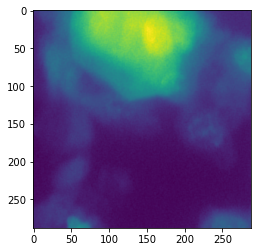

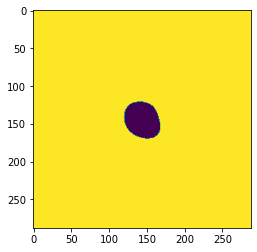

1


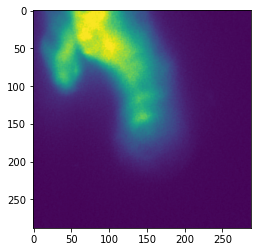

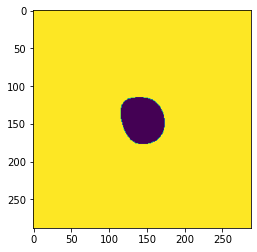

2


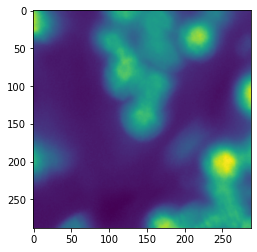

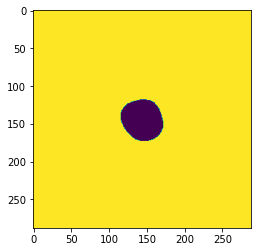

3


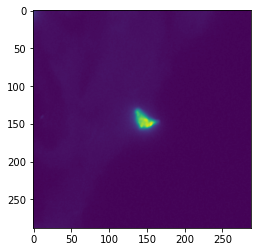

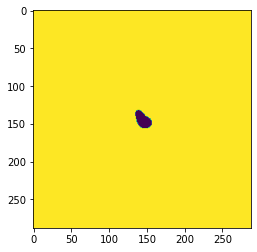

4


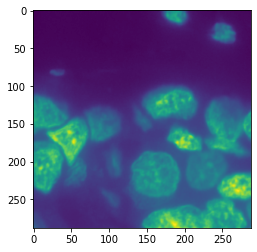

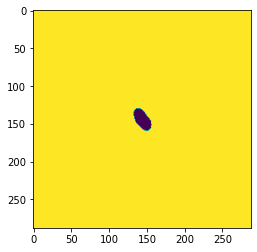

5


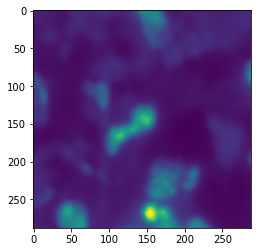

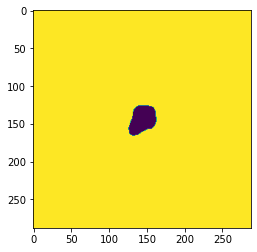

6


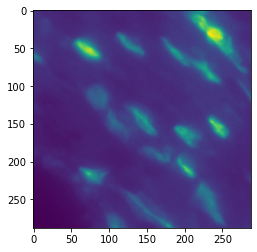

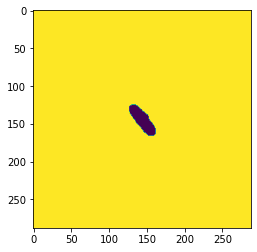

7


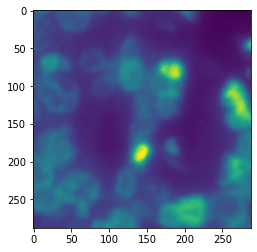

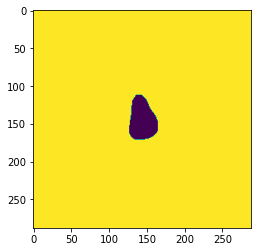

8


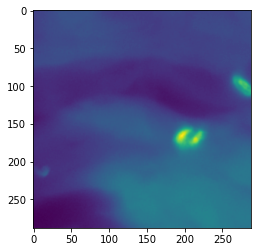

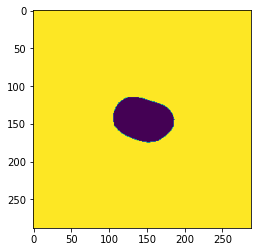

9


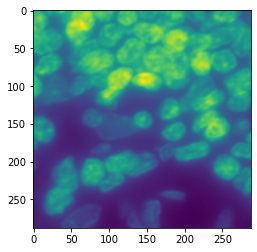

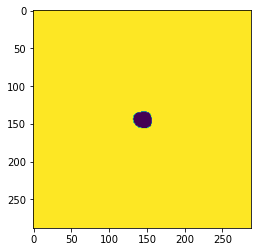

In [15]:
#float16
for i in range(10):
    print(i)
    plt.imshow(allImg_patch[trainIdx[i]][0])
    plt.show()
    plt.imshow(allmasks_patch[trainIdx[i]][0])
    plt.show()

0


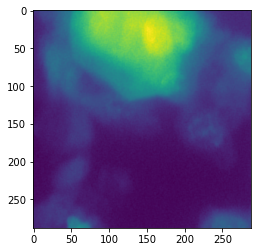

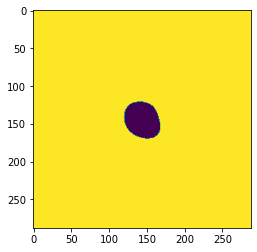

1


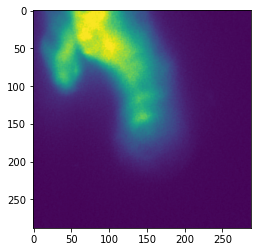

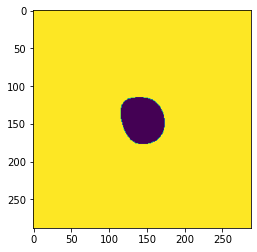

2


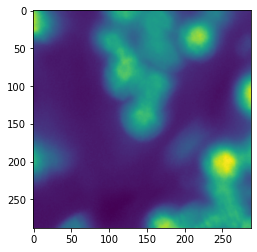

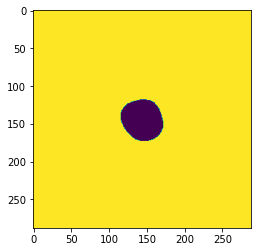

3


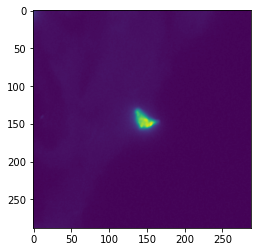

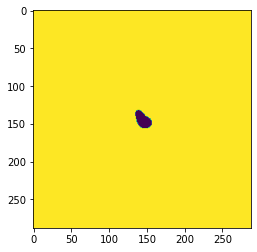

4


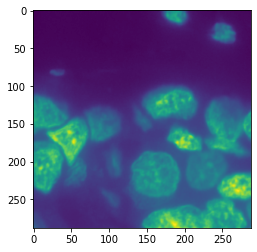

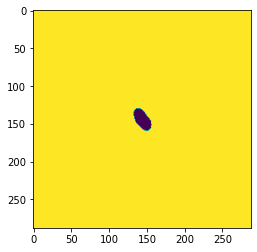

5


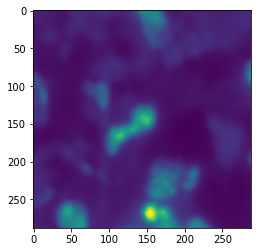

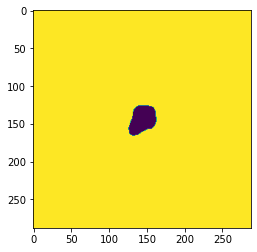

6


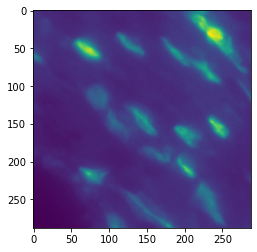

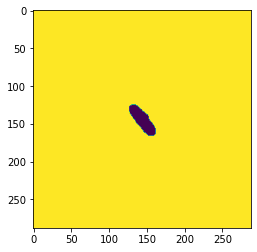

7


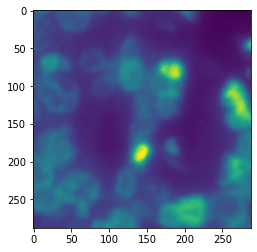

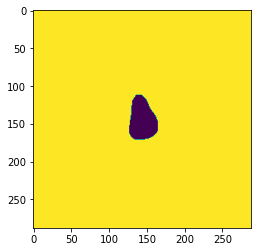

8


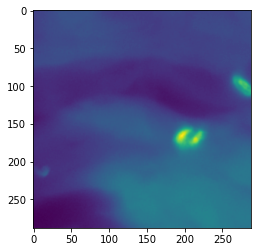

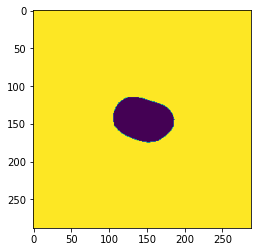

9


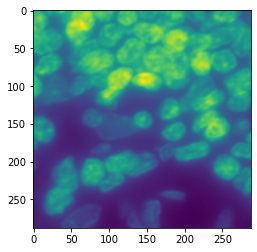

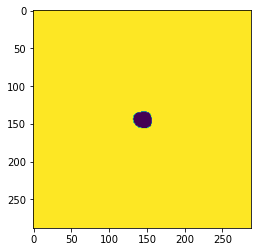

In [7]:
#float32
for i in range(10):
    print(i)
    plt.imshow(allImg_patch[trainIdx[i]][0])
    plt.show()
    plt.imshow(allmasks_patch[trainIdx[i]][0])
    plt.show()

In [5]:
#VAE settings
seed=3
epochs=2000
saveFreq=10
lr=0.00001 #initial learning rate
lr_adv=0.001
weight_decay=0 #Weight for L2 loss on embedding matrix.

# batchsize=4
batchsize=1000
kernel_size=4
stride=2
padding=1

# fc_dim1=6000
hidden1=64 #Number of channels in hidden layer 1
hidden2=128 
hidden3=256
hidden4=256
hidden5=96
fc_dim1=96*9*9
fc_dim2=6000
# fc_dim3=128
# fc_dim4=128
# gcn_dim1=2600
# adv_hidden=128

dropout=0.01
kl_weight=0.0000001
model_str='cnn_vae'

name='exp0_background'
logsavepath='/media/xinyi/dcis2idc/log/cnnvae'+name
modelsavepath='/media/xinyi/dcis2idc/models/cnnvae'+name
plotsavepath='/media/xinyi/dcis2idc/plots/cnnvae'+name


if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)

In [7]:
# Set cuda and seed
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.enabled = True
    
loss_match=torch.nn.MSELoss()
# Create model
if model_str=='cnn_vae':
    modelcnn = modelsCNN.CNN_VAE(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,fc_dim2)
    loss_kl=optimizer.optimizer_kl
    loss_x=torch.nn.MSELoss()
if model_str=='cnn_vae_sharded':
    modelcnn = modelsCNN.CNN_VAE_sharded(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,fc_dim2)
    loss_kl=optimizer.optimizer_kl
    loss_x=torch.nn.MSELoss()
    use_cuda=False

if model_str=='cnn_vae_alexnet':
    modelcnn = modelsCNN.CNN_VAE_alexnet(fc_dim1)
    loss_kl=optimizer.optimizer_kl
    loss_x=torch.nn.MSELoss(reduction='sum')

    
modelcnn.cuda()       
optimizerCNN = optim.Adam(modelcnn.parameters(), lr=lr, weight_decay=weight_decay)

In [8]:
use_cuda=True
def train(epoch):
    t = time.time()
    modelcnn.train()
    
    loss_kl_train_all=0
    loss_x_train_all=0
    loss_all=0
    ntrainBatches=int(np.ceil(trainIdx.shape[0]/batchsize))
    for i in range(ntrainBatches):
#         if i%200==0:
#         print(i)
        trainIdx_i=trainIdx[i*batchsize:min((i+1)*batchsize,trainIdx.shape[0])]
        trainInput=torch.tensor(allImg_patch[trainIdx_i])
        maski=torch.tensor(allmasks_patch[trainIdx_i])
#         print(trainInput.shape)

        if use_cuda:
            trainInput=trainInput.cuda().float()
            maski=maski.cuda()
        optimizerCNN.zero_grad()

        recon, z, mu, logvar = modelcnn(trainInput)

        loss_kl_train=loss_kl(mu, logvar)
        loss_x_train=loss_x(recon[maski], trainInput[maski])
        loss=loss_kl_train*kl_weight+loss_x_train
        
        
        loss_kl_train_all+=loss_kl_train.item()
        loss_x_train_all+=loss_x_train.item()
        loss_all+=loss.item()
        
        loss.backward()
        optimizerCNN.step()

    loss_kl_train_all=loss_kl_train_all/ntrainBatches
    loss_x_train_all=loss_x_train_all/ntrainBatches
    loss_all=loss_all/ntrainBatches
    
    with torch.no_grad():
        modelcnn.eval()
        loss_val_all=0
        nvalBatches=int(np.ceil(valIdx.shape[0]/batchsize))
        for i in range(nvalBatches):
            valIdx_i=valIdx[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]
            valInput=torch.tensor(allImg_patch[valIdx_i])
            maski=torch.tensor(allmasks_patch[valIdx_i])
            if use_cuda:
                valInput=valInput.cuda().float()
                maski=maski.cuda()
            recon,z, mu, logvar = modelcnn(valInput)

            loss_val=loss_x(recon[maski], valInput[maski]).item()

            loss_val_all+=loss_val

        loss_val_all=loss_val_all/nvalBatches
    
    print('Epoch: {:04d}'.format(epoch),
          'loss_train: {:.4f}'.format(loss_all),
          'loss_kl_train: {:.4f}'.format(loss_kl_train_all),
          'loss_x_train: {:.4f}'.format(loss_x_train_all),
          'loss_val: {:.4f}'.format(loss_val_all),
          'time: {:.4f}s'.format(time.time() - t))
    return loss_all,loss_kl_train_all,loss_x_train_all,loss_val_all

    
train_loss_ep=[None]*epochs
train_loss_kl_ep=[None]*epochs
train_loss_x_ep=[None]*epochs
val_loss_ep=[None]*epochs
t_ep=time.time()

# pre_t=4
pre_t=-1
for ep in range(epochs):
# for ep in range(10000,20000):
    train_loss_ep[ep],train_loss_kl_ep[ep],train_loss_x_ep[ep],val_loss_ep[ep]=train(ep)

        
    if ep%saveFreq == (saveFreq-1):
        torch.save(modelcnn.cpu().state_dict(), os.path.join(modelsavepath,str(ep)+'.pt'))
    if use_cuda:
        modelcnn.cuda()
        torch.cuda.empty_cache()
print(' total time: {:.4f}s'.format(time.time() - t_ep))

Epoch: 0000 loss_train: 0.0332 loss_kl_train: 3883.7222 loss_x_train: 0.0328 loss_val: 0.0074 time: 613.4810s
Epoch: 0001 loss_train: 0.0056 loss_kl_train: 14.2727 loss_x_train: 0.0056 loss_val: 0.0036 time: 596.9501s
Epoch: 0002 loss_train: 0.0031 loss_kl_train: 18.7084 loss_x_train: 0.0031 loss_val: 0.0024 time: 624.5058s
Epoch: 0003 loss_train: 0.0022 loss_kl_train: 21.7755 loss_x_train: 0.0022 loss_val: 0.0019 time: 605.1554s
Epoch: 0004 loss_train: 0.0018 loss_kl_train: 24.1759 loss_x_train: 0.0018 loss_val: 0.0015 time: 608.7175s
Epoch: 0005 loss_train: 0.0015 loss_kl_train: 25.9986 loss_x_train: 0.0015 loss_val: 0.0013 time: 623.3154s
Epoch: 0006 loss_train: 0.0013 loss_kl_train: 27.2989 loss_x_train: 0.0013 loss_val: 0.0012 time: 607.7401s
Epoch: 0007 loss_train: 0.0012 loss_kl_train: 28.2428 loss_x_train: 0.0012 loss_val: 0.0011 time: 614.4722s
Epoch: 0008 loss_train: 0.0011 loss_kl_train: 28.9433 loss_x_train: 0.0011 loss_val: 0.0010 time: 610.7433s
Epoch: 0009 loss_train: 0.

KeyboardInterrupt: 

In [9]:
torch.save(modelcnn.cpu().state_dict(), os.path.join(modelsavepath,str(ep)+'.pt'))

In [10]:
with open(os.path.join(logsavepath,'train_loss'), 'wb') as output:
    pickle.dump(train_loss_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_kl'), 'wb') as output:
    pickle.dump(train_loss_kl_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_x'), 'wb') as output:
    pickle.dump(train_loss_x_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss'), 'wb') as output:
    pickle.dump(val_loss_ep, output, pickle.HIGHEST_PROTOCOL)


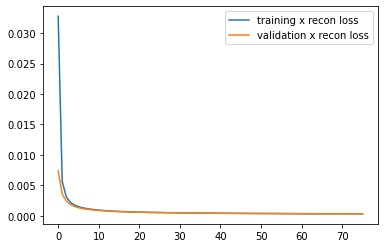

In [13]:
plt.plot(np.arange(epochs),train_loss_x_ep)
plt.plot(np.arange(epochs),val_loss_ep)
# plt.plot(np.arange(epochs),train_loss_kl_ep)
plt.legend(['training x recon loss','validation x recon loss','training kl loss'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'loss_seed3_x.jpg'))
plt.show()


In [15]:
#test loss
with torch.no_grad():
    modelcnn.cuda()
    modelcnn.eval()
    loss_test_all=0
    ntestBatches=int(np.ceil(testIdx.shape[0]/batchsize))
    for i in range(ntestBatches):
        testIdx_i=testIdx[i*batchsize:min((i+1)*batchsize,testIdx.shape[0])]
        testInput=torch.tensor(allImg_patch[testIdx_i])
        maski=torch.tensor(allmasks_patch[testIdx_i])
        if use_cuda:
            testInput=testInput.cuda().float()
            maski=maski.cuda()
            
        recon,z, mu, logvar = modelcnn(testInput)

        loss_test=loss_x(recon[maski], testInput[maski]).item()

        loss_test_all+=loss_test

    loss_test_all=loss_test_all/ntestBatches
print(loss_test_all)

0.00031469643676415257


0


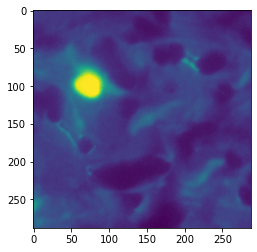

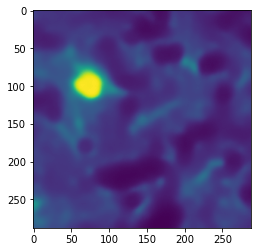

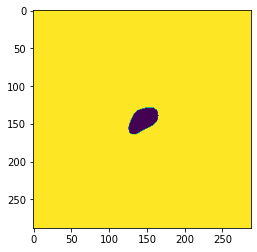

1


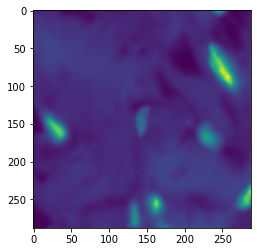

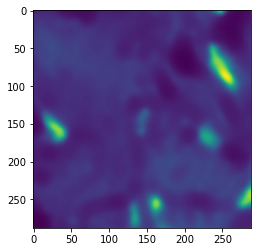

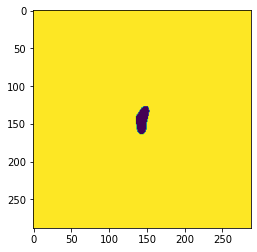

2


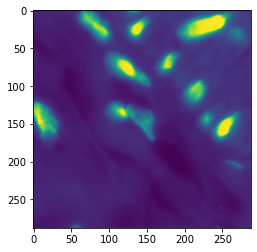

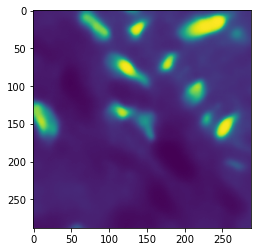

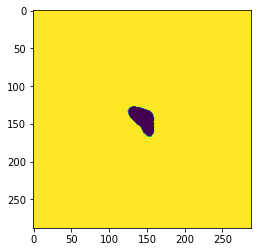

3


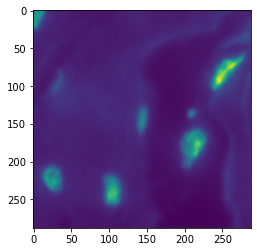

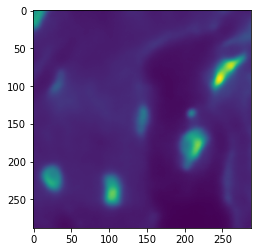

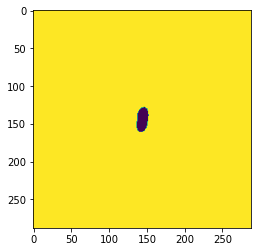

4


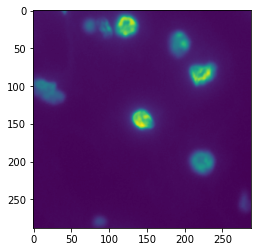

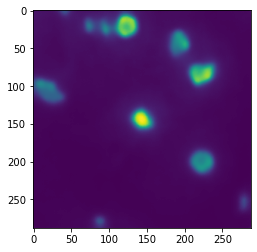

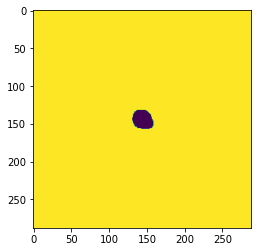

5


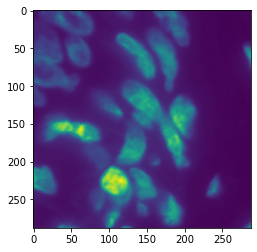

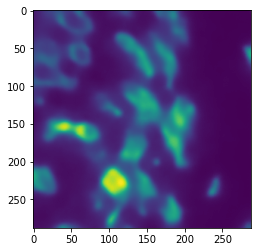

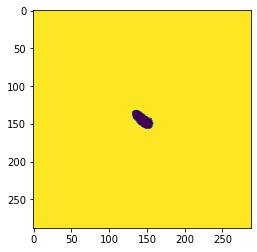

6


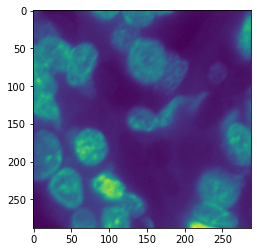

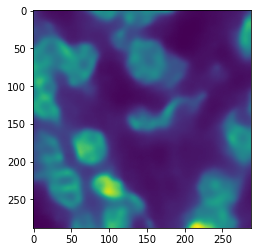

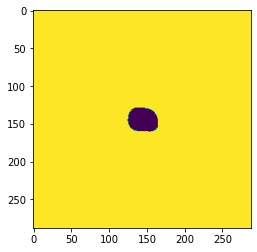

7


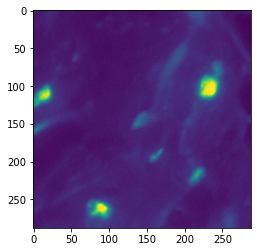

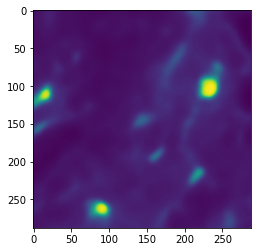

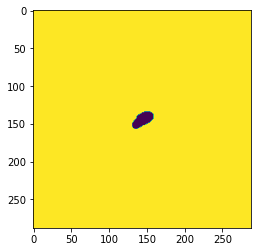

8


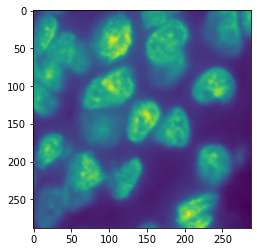

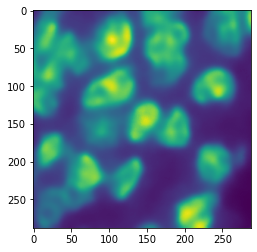

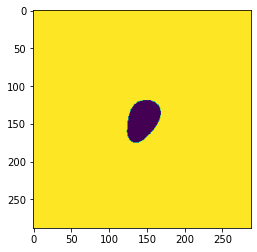

9


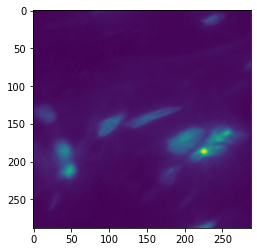

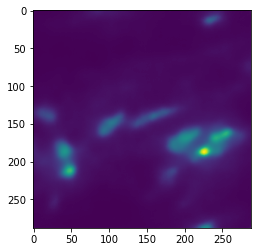

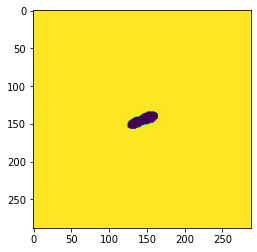

In [17]:
for i in range(10):
    print(i)
    plt.imshow(testInput[i][0].cpu().detach().numpy())
    plt.show()
    plt.imshow(recon[i][0].cpu().detach().numpy())
    plt.show()
    plt.imshow(maski[i][0].cpu().detach().numpy())
    plt.show()

In [ ]:
for i in range(10):
    print(i)
    plt.imshow(testInput[i][0].cpu().detach().numpy())
    plt.show()
    plt.imshow(recon[i][0].cpu().detach().numpy())
    plt.show()
    plt.imshow(maski[i][0].cpu().detach().numpy())
    plt.show()

In [20]:
testInput[maski].shape

torch.Size([74725640])

In [25]:
testInput.cpu().detach().numpy().size

75893760

In [28]:
#compute latent
ep=76
use_cuda=True
# modelcnn.load_state_dict(torch.load(os.path.join(modelsavepath,str(ep)+'.pt')))
latent=np.zeros((allImg_patch.shape[0],fc_dim2))
with torch.no_grad():
    modelcnn.cuda()
    modelcnn.eval()
    nplotBatches=int(np.ceil(allImg_patch.shape[0]/batchsize))
    for i in range(nplotBatches):
        plotInput=torch.tensor(allImg_patch[i*batchsize:min((i+1)*batchsize,allImg_patch.shape[0])])
        if use_cuda:
            plotInput=plotInput.cuda().float()
        recon,z, mu, logvar = modelcnn(plotInput)
        latent[i*batchsize:min((i+1)*batchsize,allImg_patch.shape[0])]=mu.cpu().detach().numpy()


In [34]:
import umap

In [35]:
#umap
# np.random.seed(3)
# plotPCT=0.1
# plottingIdx=np.array([])
# for s in np.unique(allImgNames):
#     nsamples=int(np.sum(allImgNames==s)*plotPCT)
#     plottingIdx=np.concatenate((plottingIdx,
#                                 np.random.choice(np.arange(allImgNames.shape[0])[allImgNames==s],nsamples,replace=False)))
n_neighbors=10
min_dist=0.25

# reducer = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,random_state=seed).fit(latent[plottingIdx.astype(int)])
savenameAdd='_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))+'epoch'+str(ep)

In [27]:
with open(os.path.join(modelsavepath,'umap'+savenameAdd), 'wb') as output:
    pickle.dump(reducer, output, pickle.HIGHEST_PROTOCOL)

In [11]:
with open(os.path.join(datadir,'processed','train_cnnvae_names'), 'rb') as input:
    allImgNames=pickle.load(input)


In [29]:
np.random.seed(seed)
def plotembeddingbyCT(ctlist,savename,excludelist,embedding,savepath,plotname,plotdimx=0,plotdimy=1,savenameAdd='',img=None,ncol=5):
    celltypes=np.unique(ctlist)
#     print(celltypes)
    celltypes_dict={}
    idx=0
    for ct in celltypes:
        celltypes_dict[ct]=idx
        idx+=1
        
    colortest=sns.color_palette("husl", celltypes.size)
#     colortest=sns.color_palette("husl", 9)
#     np.random.shuffle(colortest)
    fig, ax = plt.subplots(dpi=400)
    if not img is None:
        plt.imshow(img,cmap='bone')
    for ct in celltypes:
        if ct in excludelist:
            continue
        idx=(ctlist==ct)
        if not img is None:
            ax.scatter(
                embedding[idx, plotdimy],
                embedding[idx, plotdimx],
                color=colortest[celltypes_dict[ct]],label=ct,s=0.8,alpha=0.5
    #             color=colortest[int(ct)],label=ct,s=1.5,alpha=0.5
                )
        else:
            ax.scatter(
                embedding[idx, plotdimx],
                embedding[idx, plotdimy],
                color=colortest[celltypes_dict[ct]],label=ct,s=0.8,alpha=0.5
    #             color=colortest[int(ct)],label=ct,s=1.5,alpha=0.5
                )

    plt.gca().set_aspect('equal', 'datalim')
    fig.set_figheight(5)
    fig.set_figwidth(5)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])
    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=ncol,prop={'size': 6})
#     ax.legend(ncol=3)
#     plt.title(plotname+' embedding', fontsize=12)
    plt.tight_layout()
    plt.savefig(os.path.join(savepath,savename+savenameAdd+'.jpg'),bbox_inches='tight')
#     plt.show()
    
#     fig.clf()
    plt.close('all')
    
    gc.collect()
    
np.random.seed(seed)
def plotembeddingbyCT_contrast(ctlist,savename,excludelist,embedding,savepath,plotname,plotdimx=0,plotdimy=1,savenameAdd='',maxplot=None): 
    celltypes=np.unique(ctlist)
    celltypes_dict={}
    idx=0
    for ct in celltypes:
        celltypes_dict[ct]=idx
        idx+=1

    colortest=sns.color_palette("tab10")
    if not os.path.exists(os.path.join(savepath)):
        os.makedirs(savepath)

    for ct in celltypes:
        if maxplot and int(ct)>maxplot:
            continue
        fig, ax = plt.subplots()
        if ct == 'Unassigned':
            continue

        idx=(ctlist!=ct)
        ax.scatter(
            embedding[idx, plotdimx],
            embedding[idx, plotdimy],
            color=colortest[1],label='others',s=1,alpha=0.5
            )

        idx=(ctlist==ct)
        ax.scatter(
            embedding[idx, plotdimx],
            embedding[idx, plotdimy],
            color=colortest[0],label=ct,s=3,alpha=0.5
            )

        plt.gca().set_aspect('equal', 'datalim')
        fig.set_figheight(10)
        fig.set_figwidth(10)
        ax.legend()
#         plt.title(plotname+' embedding', fontsize=24)
        plt.gcf().savefig(os.path.join(savepath,savename+'_'+str(ct)+savenameAdd+'.jpg'))
#         plt.show()
#         nplot+=1
        
    
#         fig.clf()
        plt.close('all')
        gc.collect()

In [13]:
plottype='umap'
sampledir=plotsavepath
savedir=os.path.join(sampledir,'embedding_'+plottype)
clustersavedir=os.path.join(sampledir,'cluster')
if not os.path.exists(sampledir):
    os.mkdir(sampledir)
if not os.path.exists(savedir):
    os.mkdir(savedir)
if not os.path.exists(clustersavedir):
    os.mkdir(clustersavedir)

In [31]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
pca=PCA(copy=False)
plotepoch=str(ep)
def clusterMinibatchKmean_single(inArray,ncluster,n_pcs,batchsize=400):
    n_pcs=np.min([inArray.shape[0]-1,inArray.shape[1]-1,n_pcs])
    batchsize=int(np.min([(inArray.shape[0]-1)/3,(inArray.shape[1]-1)/3,batchsize]))
    
    labels = MiniBatchKMeans(n_clusters=ncluster,random_state=seed,batch_size=batchsize).fit_predict(inArray[:,:n_pcs])
    return labels

def clusterMinibatchKmean(inArray,nclusterL,n_pcs,sobj_coord_np,savenameAdd=''):
    for ncluster in nclusterL:
        clusterRes=clusterMinibatchKmean_single(inArray,ncluster,n_pcs)
#         print(clusterRes.shape)
        savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+savenameAdd
        with open(os.path.join(clustersavedir,savenamecluster), 'wb') as output:
            pickle.dump(clusterRes, output, pickle.HIGHEST_PROTOCOL)
        plotembeddingbyCT(clusterRes,'minibatchkmean_location',[],sobj_coord_np,savedir,'location'+' of '+s,savenameAdd=savenamecluster)
        plotembeddingbyCT_contrast(clusterRes,'minibatchkmean_location',[],sobj_coord_np,os.path.join(savedir,'contrast'),'location'+' of '+s,savenameAdd=savenamecluster)
def clusterMinibatchKmean_allsample(savedir,clustersavedir,inArray,nclusterL,n_pcs,sobj_coord_np,samplenameList,savenameAdd=''):
    inArray=pca.fit_transform(inArray)
    for ncluster in nclusterL:
        clusterRes=clusterMinibatchKmean_single(inArray,ncluster,n_pcs)
        savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+savenameAdd
        with open(os.path.join(clustersavedir,savenamecluster), 'wb') as output:
            pickle.dump(clusterRes, output, pickle.HIGHEST_PROTOCOL)
#         plotembeddingbyCT(clusterRes,'minibatchkmean',[],embedding,savedir,plottype+' of all samples',savenameAdd=savenamecluster)
#         plotembeddingbyCT_contrast(clusterRes,'minibatchkmean',[],embedding,os.path.join(savedir,'contrast'),plottype+' of all samples',savenameAdd=savenamecluster,maxplot=50)
        
        plotsamples=np.unique(samplenameList)
        np.random.shuffle(plotsamples)
        for s in plotsamples:
            sidx=(samplenameList==s)
            img=io.imread(os.path.join(datadir,'_'.join(s.split('_')[:-1]),'zproject/dna',s.split('_')[-1] +'.tif'))
            plotembeddingbyCT(clusterRes[sidx],'minibatchkmean_location'+s,[],sobj_coord_np[sidx],savedir,'location'+' of '+s,savenameAdd=savenamecluster,img=img)
#             plotembeddingbyCT_contrast(clusterRes[sidx],'minibatchkmean_location'+s,[],sobj_coord_np[sidx],os.path.join(savedir,'contrast'),'location'+' of '+s,savenameAdd=savenamecluster,maxplot=50)

         

In [6]:
with open(os.path.join(datadir,'processed','train_cnnvae_coord'), 'rb') as output:
    coordlist=pickle.load(output)

In [7]:
with open(os.path.join(datadir,'processed','train_cnnvae_names'), 'rb') as input:
    allImgNames=pickle.load(input)

KeyboardInterrupt: 

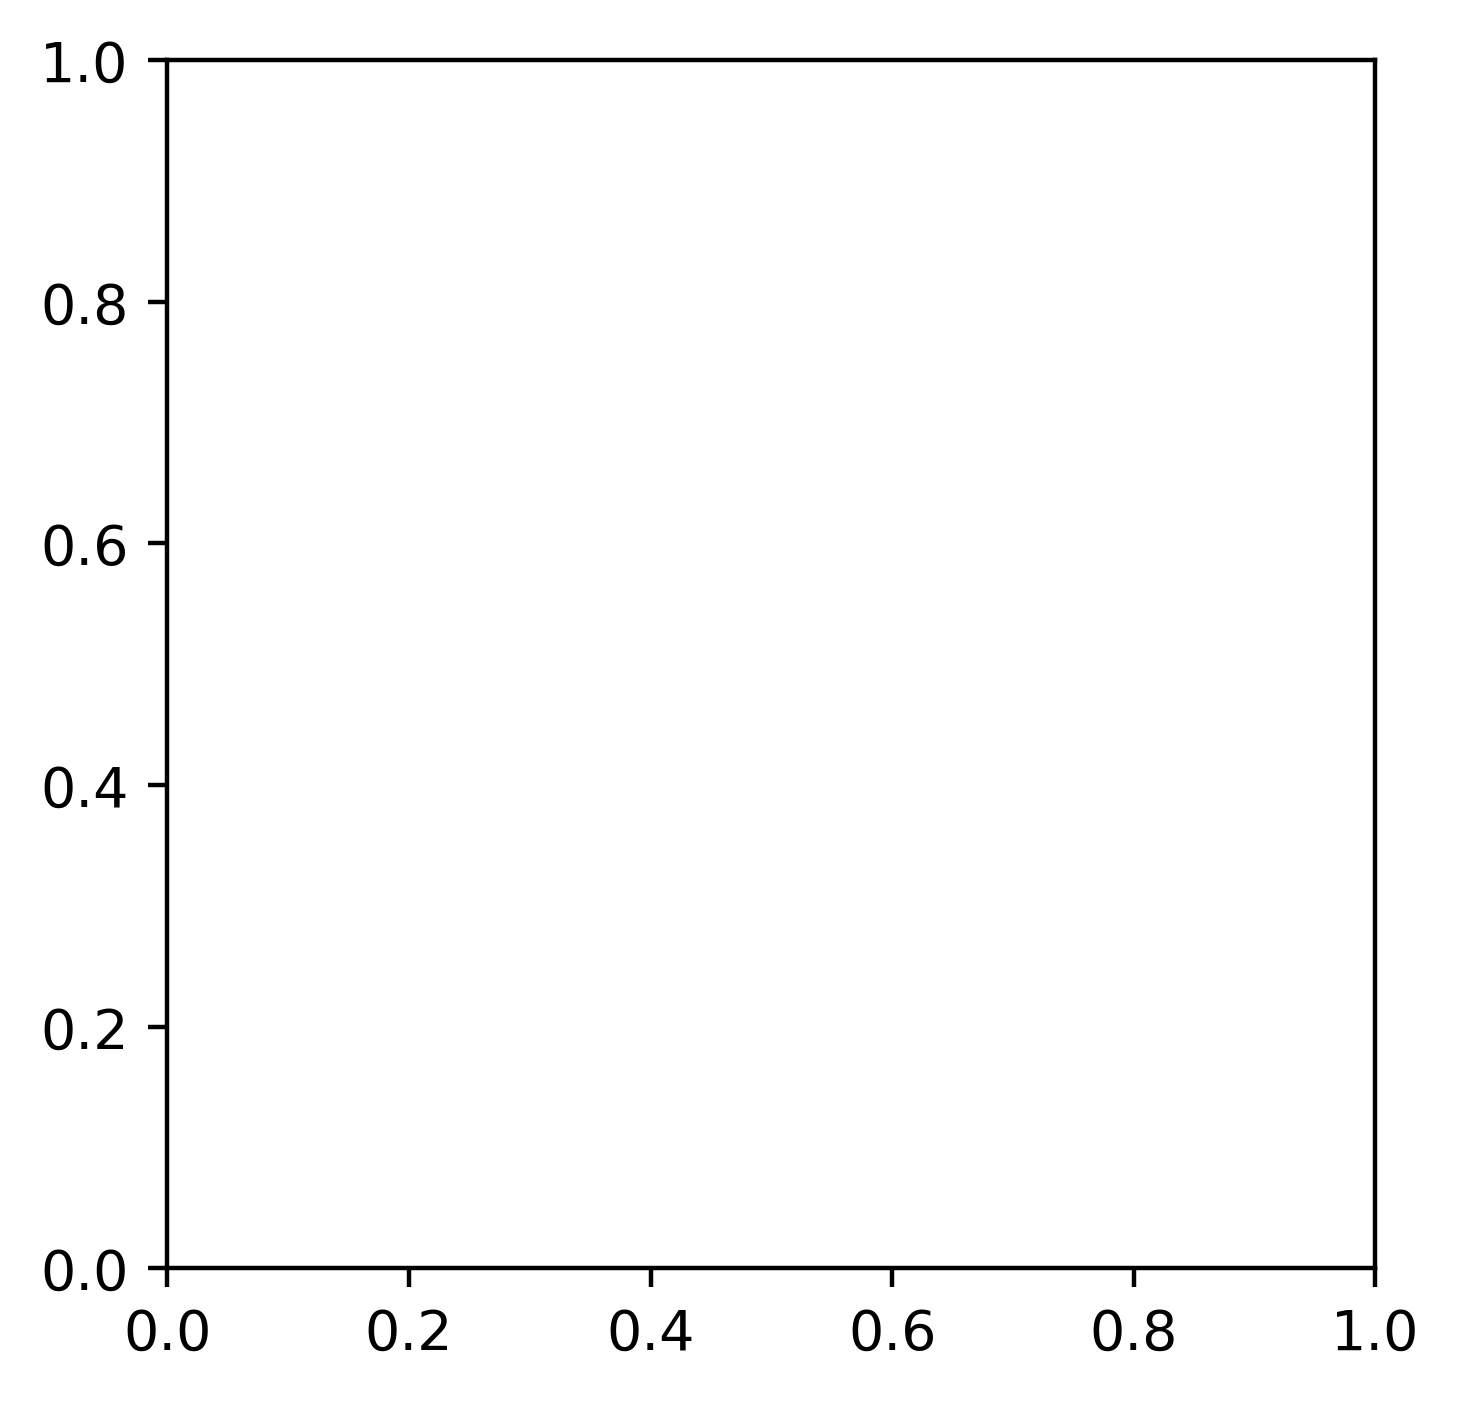

In [37]:
np.random.seed(6)
plotPCT=4500
n_pcs=50
plottingIdx_i=np.array([])

for i in range(1):
    for s in np.unique(allImgNames):
        nsamples=min(int(np.sum(allImgNames==s)),plotPCT)
        plottingIdx_i=np.concatenate((plottingIdx_i,
                                    np.random.choice(np.arange(allImgNames.shape[0])[allImgNames==s],nsamples,replace=False)))
#     clusterMinibatchKmean_allsample(savedir,clustersavedir,latent[plottingIdx_i.astype(int)],[4,8,12],n_pcs,coordlist[plottingIdx_i.astype(int)],allImgNames[plottingIdx_i.astype(int)],'_plottingIdx_'+str(plotPCT)+'_'+str(i))
    clusterMinibatchKmean_allsample(savedir,clustersavedir,latent,[8,12,20],n_pcs,coordlist[plottingIdx_i.astype(int)],allImgNames[plottingIdx_i.astype(int)],'_plottingIdx_'+str(plotPCT)+'_'+str(i))
    gc.collect()

In [8]:
#plot by disease progression
br1003aSpecs=pd.read_excel('/media/xinyi/dcis2idc/data/BR1003a specs.xlsx',header=10)
br301Specs=pd.read_excel('/media/xinyi/dcis2idc/data/BR301 specs.xlsx',header=10)
br8018aSpecs=pd.read_excel('/media/xinyi/dcis2idc/data/BR8018a specs.xlsx',header=10)
br1003aSpecs.index=br1003aSpecs.loc[:,'Position']
br301Specs.index=br301Specs.loc[:,'Position']
br8018aSpecs.index=br8018aSpecs.loc[:,'Position']

progList=np.copy(allImgNames)
for s in np.unique(allImgNames):
    ssplit=s.split('_')
    if 'br1003a'==ssplit[0]:
        prog_s=br1003aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br301'==ssplit[0]:
        prog_s=br301Specs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br8018a'==ssplit[0]:
        prog_s=br8018aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    progList[allImgNames==s]=prog_s

In [10]:
np.random.seed(6)
plotPCT=4500
n_pcs=50
plottingIdx_i=np.array([])

for i in range(1):
    for s in np.unique(allImgNames):
        nsamples=min(int(np.sum(allImgNames==s)),plotPCT)
        plottingIdx_i=np.concatenate((plottingIdx_i,
                                    np.random.choice(np.arange(allImgNames.shape[0])[allImgNames==s],nsamples,replace=False)))


In [14]:
#Sample 10 nuclei/pathology from each cluster
ncells=10
plotsavenameAdd='_plottingIdx_'+str(plotPCT)+'_'+str(i)
plotepoch=76

for ncluster in [8]:
    savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+plotsavenameAdd
    with open(os.path.join(clustersavedir,savenamecluster), 'rb') as output:
        clusterRes=pickle.load(output)
    clusterplotsavepath=os.path.join(clustersavedir,savenamecluster+'_plots')
    if not os.path.exists(clusterplotsavepath):
        os.mkdir(clusterplotsavepath)
        
    progs=np.unique(progList[plottingIdx_i.astype(int)])
    for p in range(progs.size):
        img_p=allImg_patch[progList[plottingIdx_i.astype(int)]==progs[p]]
        cluster_p=clusterRes[progList[plottingIdx_i.astype(int)]==progs[p]]
        plotExample=np.zeros((np.unique(cluster_p).size*(patchsize+1)*2,ncells*(patchsize+1)*2))
        for c in range(np.unique(cluster_p).size):
            clusteridx=np.arange(img_p.shape[0])[cluster_p==np.unique(cluster_p)[c]]
            np.random.seed(6)
            cp_plot=np.random.choice(clusteridx,min(ncells,clusteridx.size),replace=False)
            for cp_i in range(cp_plot.size):
                plotExample[c*(patchsize*2+2):c*(patchsize*2+2)+patchsize*2,cp_i*(patchsize*2+2):cp_i*(patchsize*2+2)+patchsize*2]=img_p[cp_plot[cp_i]]
        fig, ax = plt.subplots(figsize=(20,20))
        img = ax.imshow(plotExample)
        ax.set_yticks(np.arange(np.unique(cluster_p).size).astype(int)*(patchsize*2+2)+(patchsize+1))
        ax.set_yticklabels(np.unique(cluster_p))
        fig.tight_layout()
        plt.savefig(os.path.join(clusterplotsavepath,'plotexamples'+progs[p]+'.jpg'))
        plt.close()

In [40]:
dim1=0
dim2=1
plotembeddingbyCT(allImgNames[plottingIdx.astype(int)],'sample_umaptrain',[],reducer.embedding_,savedir,plottype+' of all samples',plotdimx=dim1,plotdimy=dim2,savenameAdd=savenameAdd+'_pc'+str(dim1)+'pc'+str(dim2),ncol=2)


/tmp/ipykernel_2765903/3669990762.py:47: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


In [59]:
plotembeddingbyCT(progList[plottingIdx.astype(int)],'prog_umaptrain',[],reducer.embedding_,savedir,plottype+' of all samples',plotdimx=dim1,plotdimy=dim2,savenameAdd=savenameAdd+'_pc'+str(dim1)+'pc'+str(dim2),ncol=2)
plotembeddingbyCT_contrast(progList[plottingIdx.astype(int)],'prog_umaptrain',[],reducer.embedding_,os.path.join(savedir,'contrast'),plottype+' of all samples',plotdimx=dim1,plotdimy=dim2,savenameAdd=savenameAdd+'_pc'+str(dim1)+'pc'+str(dim2))


KeyboardInterrupt: 

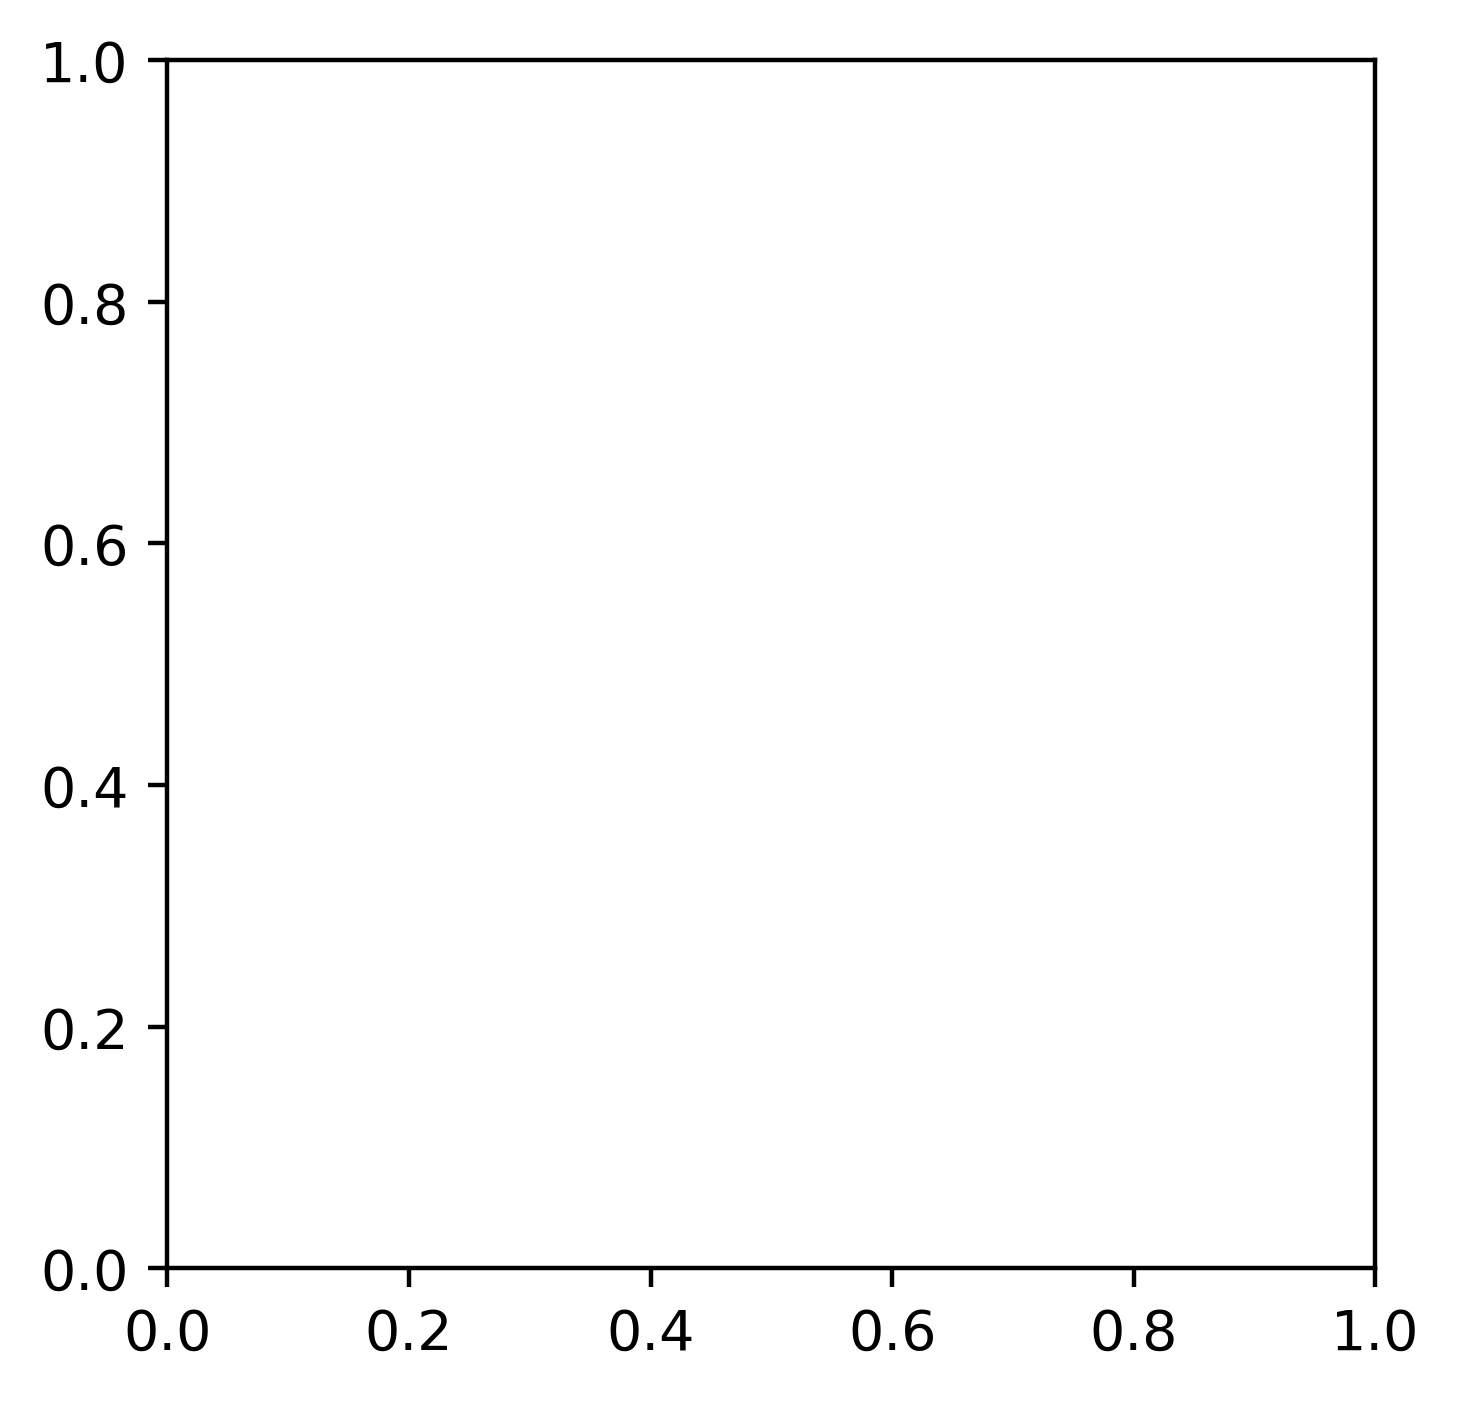

In [66]:
np.random.seed(6)
plotPCT=3000
plottingIdx_i=np.array([])
for i in range(1):
    for s in np.unique(allImgNames):
        nsamples=min(int(np.sum(allImgNames==s)),plotPCT)
        plottingIdx_i=np.concatenate((plottingIdx_i,
                                    np.random.choice(np.arange(allImgNames.shape[0])[allImgNames==s],nsamples,replace=False)))
    clusterMinibatchKmean_allsample(savedir,clustersavedir,latent[plottingIdx_i.astype(int)],[4,8,12,16,20],50,coordlist[plottingIdx_i.astype(int)],allImgNames[plottingIdx_i.astype(int)],'_plottingIdx_3000_'+str(i))

In [1]:
np.unique(allImgNames[plottingIdx.astype(int)],return_counts=True)

NameError: name 'np' is not defined

In [38]:
gc.collect()

662506